In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Phemernr2-RNR"
unique_name = "RoBERTa_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Phemernr2-RNR_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(6425, 768)

In [3]:
data = pd.read_csv("../../data/phemernr2_dataset_with_tvt.csv", sep=",")
data.head()

,tweet_id,tweet_text,label,tvt2,tvt2_1
0,552833795142209536,the east london mosque would like to offer its...,non-rumours,training,training
1,580318210609696769,breaking - a germanwings airbus a320 plane rep...,true,validation,testting
2,552798891994009601,reports that two of the dead in the #charliehe...,true,training,training
3,576790814942236672,after #putin disappeared russian tv no longer ...,non-rumours,validation,training
4,499678822598340608,saw #ferguson for myself. #justiceformichaelbr...,non-rumours,testting,testting


In [4]:
data['label'] = data['label'].replace(['true', 'unverfied', 'false'], 'rumours')

In [5]:
labels_str = ['rumours', 'non-rumours']
labels_str

['rumours', 'non-rumours']

In [6]:
labels = []
for i, d in data.iterrows():
#     lab = labels_str.index(d['label'])
    if d['label'] == "rumours":
        lab = 0
    else:
        lab = 1
    labels.append(lab)
labels[:10]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1]

In [7]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [8]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(4336, 768)
(1462, 768)
(627, 768)
(4336,)
(1462,)
(627,)


In [9]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(5798, 768)


In [10]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(5798,)


In [11]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(128),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets=inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
            
            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss/len(trainloader))
            

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()
            
                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss/len(testloader))
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
            # if saves and test_loss < best_loss:
            #     print(f"Saving after new best loss : {test_loss}")
            #     best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break
            
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_4LayerNet_L2Reg_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_4LayerNet_L2Reg_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [12]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

Multiclass Classification using 4-Layer Linear Network Cross Validation
--- FOLD 1 ----
Using cuda
Saving after new best accuracy : 90.08620689655173
Saving after new best accuracy : 90.34482758620689
Saving after new best accuracy : 94.13793103448276
-- Epoch 50, Train_Accuracy : 92.496765847348, Validation Accuracy : 92.24137931034483, Train Loss : 1.9299004524946213, Validation Loss : 0.5351945757865906
-- Epoch 100, Train_Accuracy : 93.55325571366969, Validation Accuracy : 92.32758620689656, Train Loss : 1.6131937131285667, Validation Loss : 0.5468807965517044
Saving after new best accuracy : 94.22413793103448
Saving after new best accuracy : 94.39655172413794
Saving after new best accuracy : 94.82758620689656
-- Epoch 150, Train_Accuracy : 94.41569642087107, Validation Accuracy : 93.62068965517241, Train Loss : 1.4073007516562939, Validation Loss : 0.5461314767599106
Saving after new best accuracy : 95.08620689655173
Saving after new best accuracy : 95.17241379310344
-- Epoch 200,

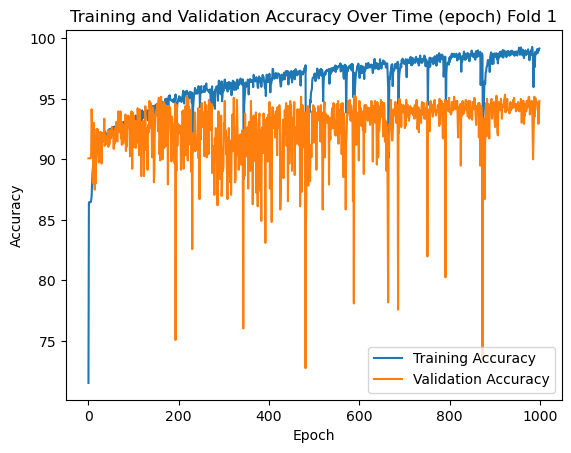

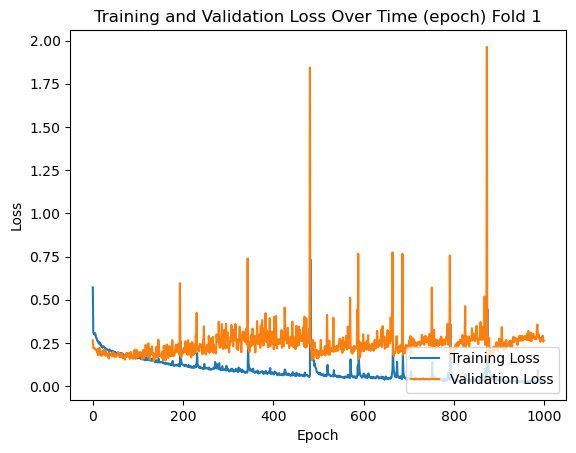

Exec Time : 89.06 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1.pth...

Train Set
Predictions : torch.Size([4638])
Binary Class Evaluation

True Positive : 3376
False Positive : 4
False Negative : 31
True Negative : 1227

Class non-rumours Evaluation
- Precision : 99.882 %
- Recall : 99.09 %
- F1 : 0.99484

Class rumours Evaluation
- Precision : 97.536 %
- Recall : 99.675 %
- F1 : 0.98594

Combined Evaluation
- Accuracy : 99.245 %
- Precision : 98.709 %
- Recall : 99.383 %
- F1 : 0.99045
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Train, 99.245, 98.709, 99.383, 0.99045, 99.882, 99.09, 0.99484, 97.536, 99.675, 0.98594, 
Confusion Matrix Scikit-learn: 
[[1227    4]
 [  31 3376]]


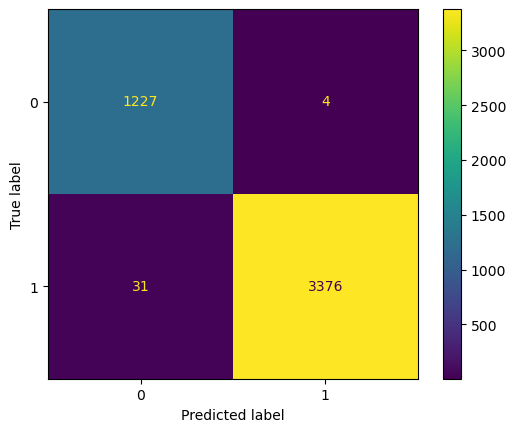


Validation Set
Predictions : torch.Size([1160])
Binary Class Evaluation

True Positive : 822
False Positive : 24
False Negative : 30
True Negative : 284

Class non-rumours Evaluation
- Precision : 97.163 %
- Recall : 96.479 %
- F1 : 0.9682

Class rumours Evaluation
- Precision : 90.446 %
- Recall : 92.208 %
- F1 : 0.91318

Combined Evaluation
- Accuracy : 95.345 %
- Precision : 93.804 %
- Recall : 94.343 %
- F1 : 0.94073
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Validation, 95.345, 93.804, 94.343, 0.94073, 97.163, 96.479, 0.9682, 90.446, 92.208, 0.91318, 
Confusion Matrix Scikit-learn: 
[[284  24]
 [ 30 822]]


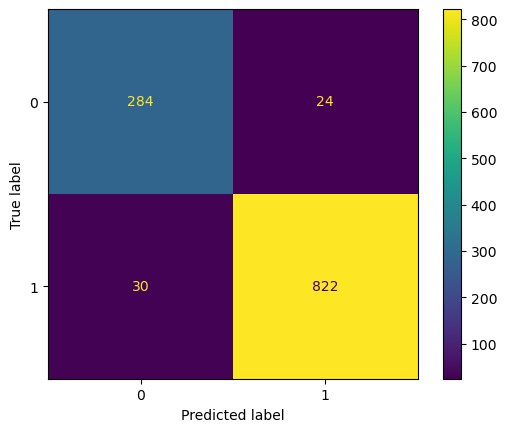


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 426
False Positive : 36
False Negative : 35
True Negative : 130

Class non-rumours Evaluation
- Precision : 92.208 %
- Recall : 92.408 %
- F1 : 0.92308

Class rumours Evaluation
- Precision : 78.788 %
- Recall : 78.313 %
- F1 : 0.7855

Combined Evaluation
- Accuracy : 88.676 %
- Precision : 85.498 %
- Recall : 85.361 %
- F1 : 0.85429
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Test, 88.676, 85.498, 85.361, 0.85429, 92.208, 92.408, 0.92308, 78.788, 78.313, 0.7855, 
627
627
Confusion Matrix Scikit-learn: 
[[130  36]
 [ 35 426]]


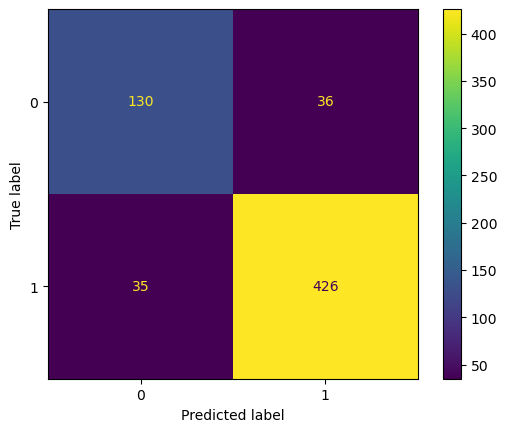

--- FOLD 2 ----
Using cuda
Saving after new best accuracy : 89.48275862068965
Saving after new best accuracy : 90.43103448275862
Saving after new best accuracy : 92.06896551724138
Saving after new best accuracy : 92.24137931034483
Saving after new best accuracy : 92.32758620689656
Saving after new best accuracy : 92.93103448275862
Saving after new best accuracy : 93.44827586206897
-- Epoch 50, Train_Accuracy : 92.06554549374731, Validation Accuracy : 92.5, Train Loss : 1.9626663774251938, Validation Loss : 0.5454046428203583
Saving after new best accuracy : 93.62068965517241
Saving after new best accuracy : 93.87931034482759
-- Epoch 100, Train_Accuracy : 93.63949978438983, Validation Accuracy : 93.79310344827586, Train Loss : 1.6180480122566223, Validation Loss : 0.48845823109149933
Saving after new best accuracy : 94.13793103448276
Saving after new best accuracy : 94.22413793103448
Saving after new best accuracy : 94.39655172413794
-- Epoch 150, Train_Accuracy : 94.48037947391117, Va

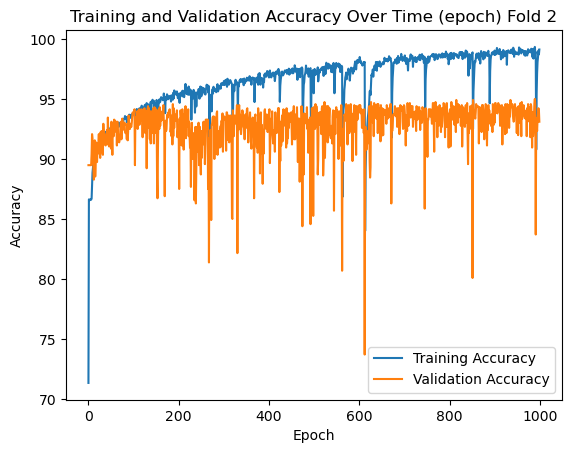

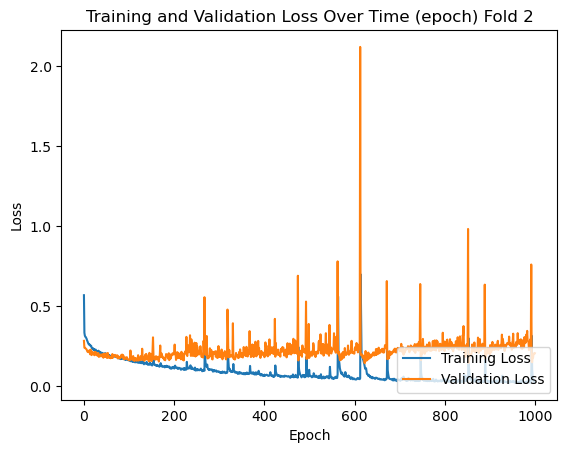

Exec Time : 59.61 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2.pth...

Train Set
Predictions : torch.Size([4638])
Binary Class Evaluation

True Positive : 3391
False Positive : 5
False Negative : 16
True Negative : 1226

Class non-rumours Evaluation
- Precision : 99.853 %
- Recall : 99.53 %
- F1 : 0.99691

Class rumours Evaluation
- Precision : 98.712 %
- Recall : 99.594 %
- F1 : 0.99151

Combined Evaluation
- Accuracy : 99.547 %
- Precision : 99.282 %
- Recall : 99.562 %
- F1 : 0.99422
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Train, 99.547, 99.282, 99.562, 0.99422, 99.853, 99.53, 0.99691, 98.712, 99.594, 0.99151, 
Confusion Matrix Scikit-learn: 
[[1226    5]
 [  16 3391]]


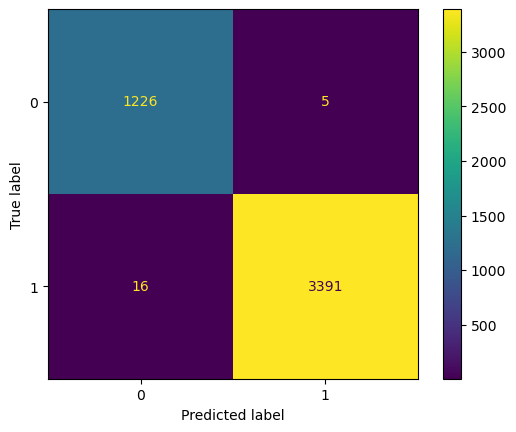


Validation Set
Predictions : torch.Size([1160])
Binary Class Evaluation

True Positive : 813
False Positive : 19
False Negative : 39
True Negative : 289

Class non-rumours Evaluation
- Precision : 97.716 %
- Recall : 95.423 %
- F1 : 0.96556

Class rumours Evaluation
- Precision : 88.11 %
- Recall : 93.831 %
- F1 : 0.90881

Combined Evaluation
- Accuracy : 95.0 %
- Precision : 92.913 %
- Recall : 94.627 %
- F1 : 0.93762
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Validation, 95.0, 92.913, 94.627, 0.93762, 97.716, 95.423, 0.96556, 88.11, 93.831, 0.90881, 
Confusion Matrix Scikit-learn: 
[[289  19]
 [ 39 813]]


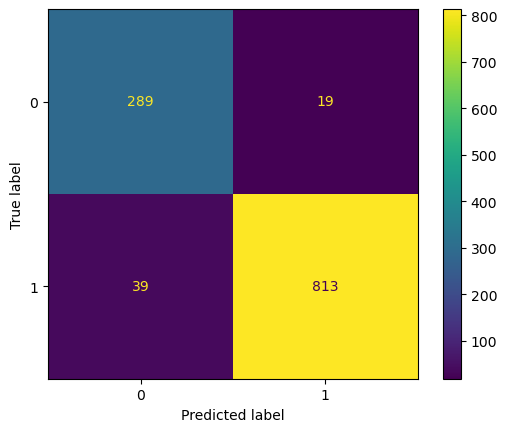


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 423
False Positive : 34
False Negative : 38
True Negative : 132

Class non-rumours Evaluation
- Precision : 92.56 %
- Recall : 91.757 %
- F1 : 0.92157

Class rumours Evaluation
- Precision : 77.647 %
- Recall : 79.518 %
- F1 : 0.78571

Combined Evaluation
- Accuracy : 88.517 %
- Precision : 85.104 %
- Recall : 85.638 %
- F1 : 0.8537
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Test, 88.517, 85.104, 85.638, 0.8537, 92.56, 91.757, 0.92157, 77.647, 79.518, 0.78571, 
627
627
Confusion Matrix Scikit-learn: 
[[132  34]
 [ 38 423]]


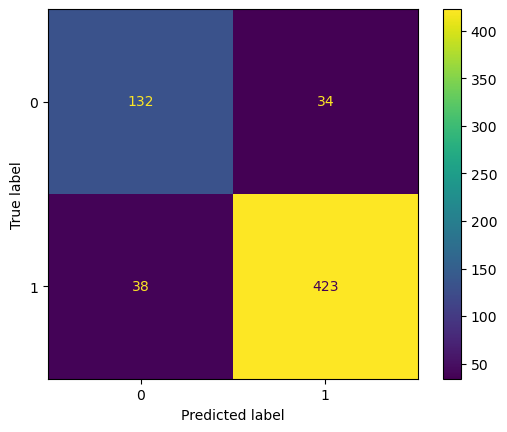

--- FOLD 3 ----
Using cuda
Saving after new best accuracy : 88.36206896551724
Saving after new best accuracy : 88.87931034482759
Saving after new best accuracy : 92.93103448275862
Saving after new best accuracy : 93.10344827586206
-- Epoch 50, Train_Accuracy : 92.6261319534282, Validation Accuracy : 92.5, Train Loss : 1.9262555241584778, Validation Loss : 0.5618098676204681
Saving after new best accuracy : 93.53448275862068
Saving after new best accuracy : 93.87931034482759
Saving after new best accuracy : 94.22413793103448
-- Epoch 100, Train_Accuracy : 93.6826218197499, Validation Accuracy : 93.70689655172414, Train Loss : 1.5859854966402054, Validation Loss : 0.48518106341362
Saving after new best accuracy : 94.39655172413794
-- Epoch 150, Train_Accuracy : 94.07072013799052, Validation Accuracy : 92.75862068965517, Train Loss : 1.4193483591079712, Validation Loss : 0.5722275227308273
Saving after new best accuracy : 94.65517241379311
-- Epoch 200, Train_Accuracy : 94.4372574385511, 

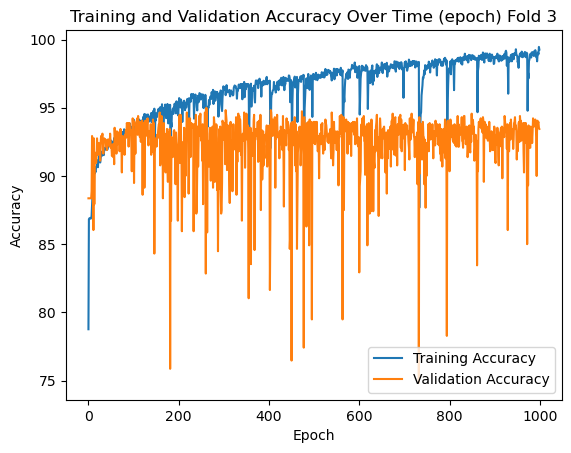

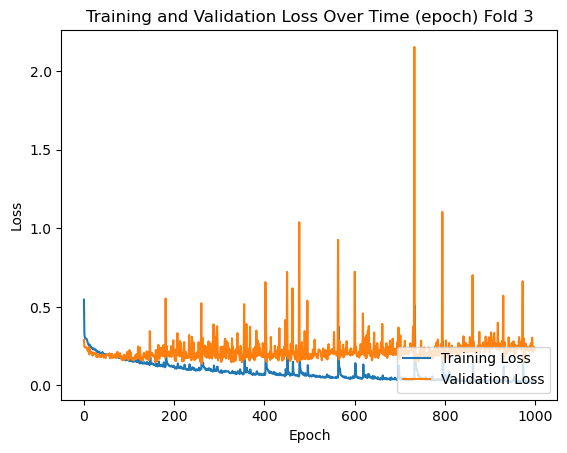

Exec Time : 60.46 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3.pth...

Train Set
Predictions : torch.Size([4638])
Binary Class Evaluation

True Positive : 3221
False Positive : 57
False Negative : 186
True Negative : 1174

Class non-rumours Evaluation
- Precision : 98.261 %
- Recall : 94.541 %
- F1 : 0.96365

Class rumours Evaluation
- Precision : 86.324 %
- Recall : 95.37 %
- F1 : 0.90621

Combined Evaluation
- Accuracy : 94.761 %
- Precision : 92.292 %
- Recall : 94.955 %
- F1 : 0.93605
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Train, 94.761, 92.292, 94.955, 0.93605, 98.261, 94.541, 0.96365, 86.324, 95.37, 0.90621, 
Confusion Matrix Scikit-learn: 
[[1174   57]
 [ 186 3221]]


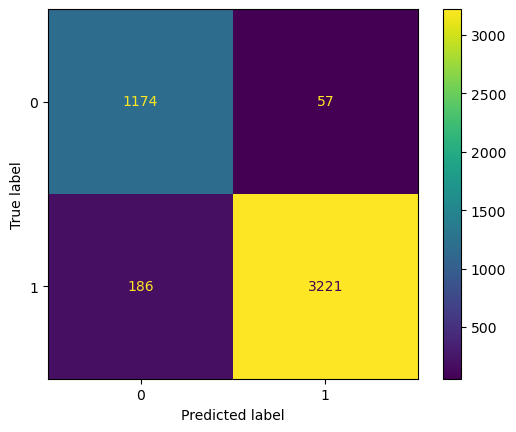


Validation Set
Predictions : torch.Size([1160])
Binary Class Evaluation

True Positive : 797
False Positive : 3
False Negative : 55
True Negative : 305

Class non-rumours Evaluation
- Precision : 99.625 %
- Recall : 93.545 %
- F1 : 0.96489

Class rumours Evaluation
- Precision : 84.722 %
- Recall : 99.026 %
- F1 : 0.91317

Combined Evaluation
- Accuracy : 95.0 %
- Precision : 92.174 %
- Recall : 96.285 %
- F1 : 0.94185
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Validation, 95.0, 92.174, 96.285, 0.94185, 99.625, 93.545, 0.96489, 84.722, 99.026, 0.91317, 
Confusion Matrix Scikit-learn: 
[[305   3]
 [ 55 797]]


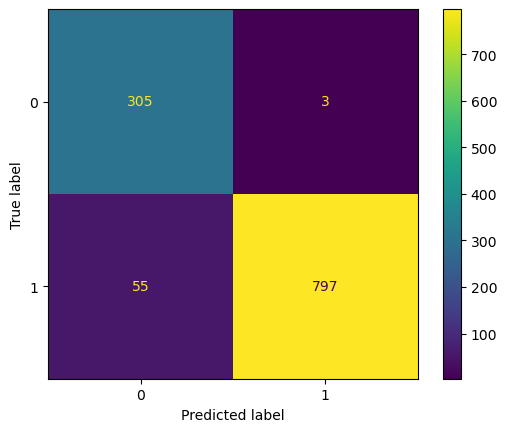


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 414
False Positive : 30
False Negative : 47
True Negative : 136

Class non-rumours Evaluation
- Precision : 93.243 %
- Recall : 89.805 %
- F1 : 0.91492

Class rumours Evaluation
- Precision : 74.317 %
- Recall : 81.928 %
- F1 : 0.77937

Combined Evaluation
- Accuracy : 87.719 %
- Precision : 83.78 %
- Recall : 85.866 %
- F1 : 0.8481
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Test, 87.719, 83.78, 85.866, 0.8481, 93.243, 89.805, 0.91492, 74.317, 81.928, 0.77937, 
627
627
Confusion Matrix Scikit-learn: 
[[136  30]
 [ 47 414]]


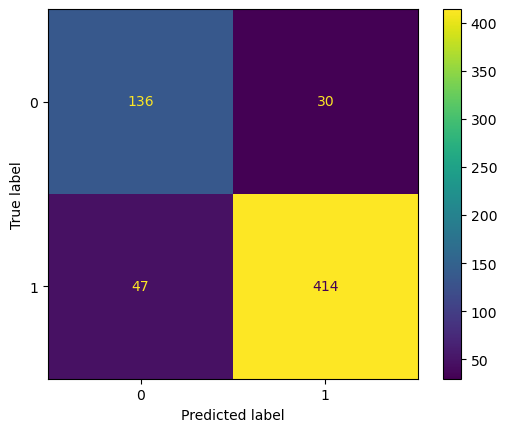

--- FOLD 4 ----
Using cuda
Saving after new best accuracy : 86.88524590163935
Saving after new best accuracy : 87.05780845556514
Saving after new best accuracy : 87.14408973252804
Saving after new best accuracy : 90.42277825711821
Saving after new best accuracy : 90.5090595340811
Saving after new best accuracy : 91.1130284728214
Saving after new best accuracy : 91.19930974978429
Saving after new best accuracy : 91.63071613459879
Saving after new best accuracy : 91.71699741156169
Saving after new best accuracy : 91.97584124245039
Saving after new best accuracy : 92.0621225194133
-- Epoch 50, Train_Accuracy : 92.67083423151541, Validation Accuracy : 90.25021570319241, Train Loss : 1.9132130593061447, Validation Loss : 0.7769476771354675
-- Epoch 100, Train_Accuracy : 93.42530717827118, Validation Accuracy : 91.2855910267472, Train Loss : 1.6217614337801933, Validation Loss : 0.810159295797348
Saving after new best accuracy : 92.49352890422779
Saving after new best accuracy : 93.270060396

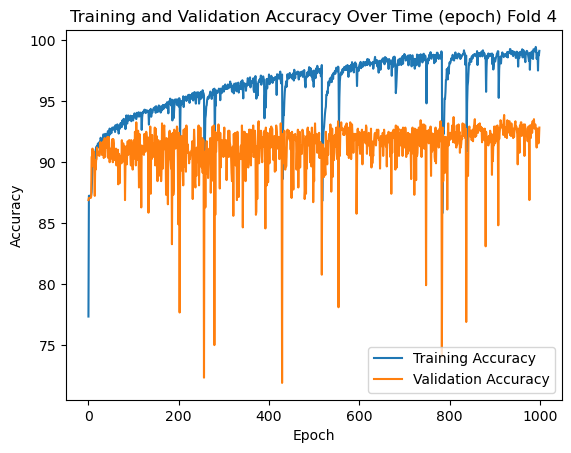

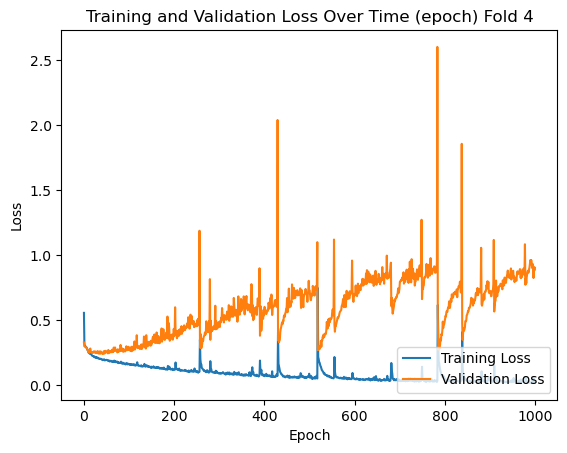

Exec Time : 66.06 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4.pth...

Train Set
Predictions : torch.Size([4639])
Binary Class Evaluation

True Positive : 3388
False Positive : 0
False Negative : 19
True Negative : 1232

Class non-rumours Evaluation
- Precision : 100.0 %
- Recall : 99.442 %
- F1 : 0.9972

Class rumours Evaluation
- Precision : 98.481 %
- Recall : 100.0 %
- F1 : 0.99235

Combined Evaluation
- Accuracy : 99.59 %
- Precision : 99.241 %
- Recall : 99.721 %
- F1 : 0.9948
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Train, 99.59, 99.241, 99.721, 0.9948, 100.0, 99.442, 0.9972, 98.481, 100.0, 0.99235, 
Confusion Matrix Scikit-learn: 
[[1232    0]
 [  19 3388]]


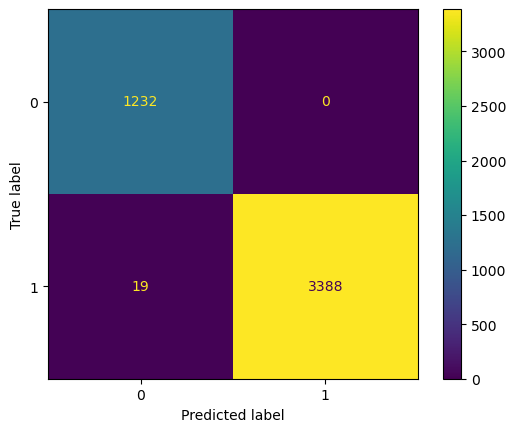


Validation Set
Predictions : torch.Size([1159])
Binary Class Evaluation

True Positive : 811
False Positive : 30
False Negative : 41
True Negative : 277

Class non-rumours Evaluation
- Precision : 96.433 %
- Recall : 95.188 %
- F1 : 0.95806

Class rumours Evaluation
- Precision : 87.107 %
- Recall : 90.228 %
- F1 : 0.8864

Combined Evaluation
- Accuracy : 93.874 %
- Precision : 91.77 %
- Recall : 92.708 %
- F1 : 0.92237
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Validation, 93.874, 91.77, 92.708, 0.92237, 96.433, 95.188, 0.95806, 87.107, 90.228, 0.8864, 
Confusion Matrix Scikit-learn: 
[[277  30]
 [ 41 811]]


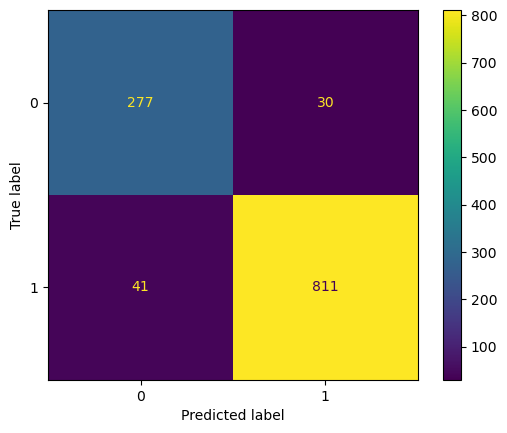


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 422
False Positive : 28
False Negative : 39
True Negative : 138

Class non-rumours Evaluation
- Precision : 93.778 %
- Recall : 91.54 %
- F1 : 0.92645

Class rumours Evaluation
- Precision : 77.966 %
- Recall : 83.133 %
- F1 : 0.80466

Combined Evaluation
- Accuracy : 89.314 %
- Precision : 85.872 %
- Recall : 87.336 %
- F1 : 0.86598
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Test, 89.314, 85.872, 87.336, 0.86598, 93.778, 91.54, 0.92645, 77.966, 83.133, 0.80466, 
627
627
Confusion Matrix Scikit-learn: 
[[138  28]
 [ 39 422]]


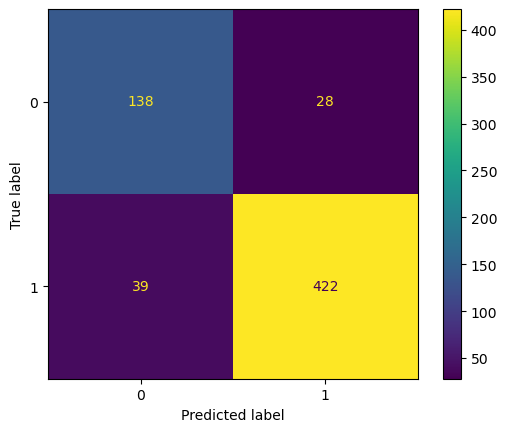

--- FOLD 5 ----
Using cuda
Saving after new best accuracy : 81.0181190681622
Saving after new best accuracy : 81.10440034512511
Saving after new best accuracy : 81.7946505608283
Saving after new best accuracy : 85.24590163934427
Saving after new best accuracy : 85.59102674719585
Saving after new best accuracy : 86.28127696289906
Saving after new best accuracy : 86.54012079378775
Saving after new best accuracy : 86.79896462467644
Saving after new best accuracy : 86.88524590163935
Saving after new best accuracy : 87.23037100949094
Saving after new best accuracy : 87.31665228645385
-- Epoch 50, Train_Accuracy : 94.43845656391464, Validation Accuracy : 86.71268334771355, Train Loss : 1.3758711125701666, Validation Loss : 1.1857681274414062
Saving after new best accuracy : 87.40293356341674
-- Epoch 100, Train_Accuracy : 94.78335848243155, Validation Accuracy : 87.05780845556514, Train Loss : 1.26684376783669, Validation Loss : 1.5746574997901917
-- Epoch 150, Train_Accuracy : 95.4731623194

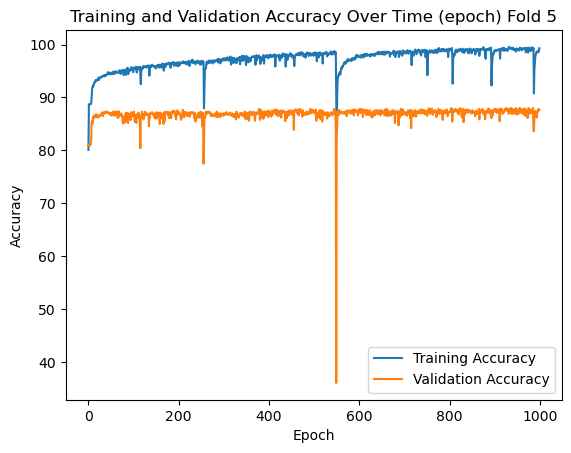

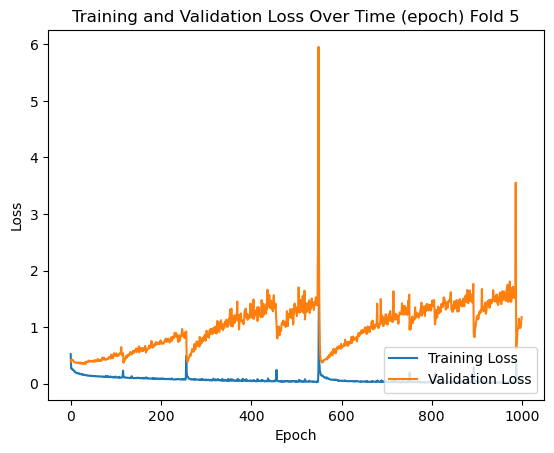

Exec Time : 128.16 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5.pth...

Train Set
Predictions : torch.Size([4639])
Binary Class Evaluation

True Positive : 3378
False Positive : 3
False Negative : 30
True Negative : 1228

Class non-rumours Evaluation
- Precision : 99.911 %
- Recall : 99.12 %
- F1 : 0.99514

Class rumours Evaluation
- Precision : 97.615 %
- Recall : 99.756 %
- F1 : 0.98674

Combined Evaluation
- Accuracy : 99.289 %
- Precision : 98.763 %
- Recall : 99.438 %
- F1 : 0.99099
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Train, 99.289, 98.763, 99.438, 0.99099, 99.911, 99.12, 0.99514, 97.615, 99.756, 0.98674, 
Confusion Matrix Scikit-learn: 
[[1228    3]
 [  30 3378]]


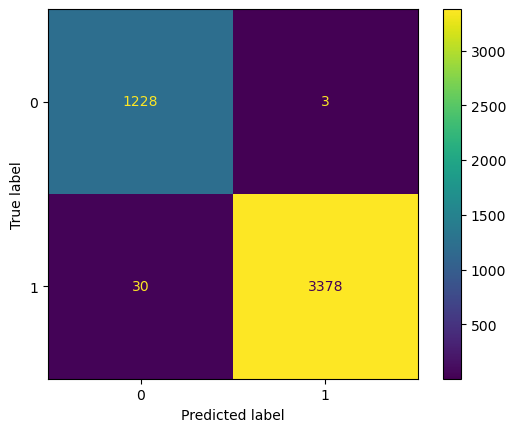


Validation Set
Predictions : torch.Size([1159])
Binary Class Evaluation

True Positive : 760
False Positive : 48
False Negative : 91
True Negative : 260

Class non-rumours Evaluation
- Precision : 94.059 %
- Recall : 89.307 %
- F1 : 0.91621

Class rumours Evaluation
- Precision : 74.074 %
- Recall : 84.416 %
- F1 : 0.78907

Combined Evaluation
- Accuracy : 88.007 %
- Precision : 84.067 %
- Recall : 86.861 %
- F1 : 0.85441
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Validation, 88.007, 84.067, 86.861, 0.85441, 94.059, 89.307, 0.91621, 74.074, 84.416, 0.78907, 
Confusion Matrix Scikit-learn: 
[[260  48]
 [ 91 760]]


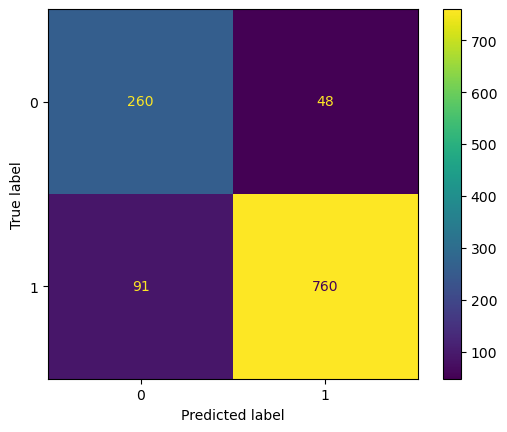


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 417
False Positive : 28
False Negative : 44
True Negative : 138

Class non-rumours Evaluation
- Precision : 93.708 %
- Recall : 90.456 %
- F1 : 0.92053

Class rumours Evaluation
- Precision : 75.824 %
- Recall : 83.133 %
- F1 : 0.7931

Combined Evaluation
- Accuracy : 88.517 %
- Precision : 84.766 %
- Recall : 86.794 %
- F1 : 0.85768
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Test, 88.517, 84.766, 86.794, 0.85768, 93.708, 90.456, 0.92053, 75.824, 83.133, 0.7931, 
627
627
Confusion Matrix Scikit-learn: 
[[138  28]
 [ 44 417]]


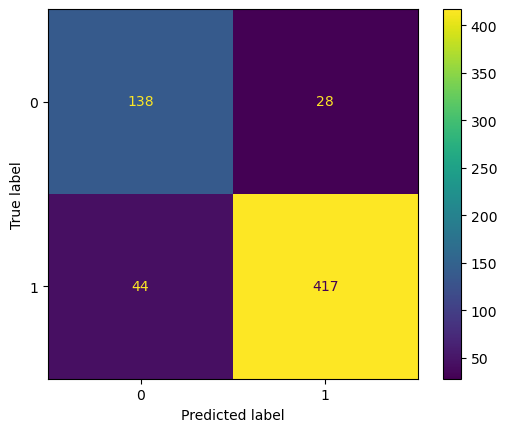

In [13]:
print("Multiclass Classification using 4-Layer Linear Network Cross Validation")

for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
       
    start = time.time()
    model_name = f"{dataset_name}_4LayerNet_L2Reg_{unique_name}_Fold{i+1}"
    model = NNClassifier(train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
    model.train_eval(torch.Tensor(train_vectors),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\nTrain Set")
    preds = model.predict(train_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nValidation Set")
    preds = model.predict(val_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nTest Set")
    preds = model.predict(test_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()